In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from sklearn.decomposition import PCA
import numpy as np
from scipy.signal import argrelextrema
import math
import random
#  first import numpy

In [2]:
def bandpass(fs, lowcut, highcut, order, ori_signal):
    # Create the filter coefficients using a Butterworth filter design
    nyquist_freq = 0.5 * fs
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = signal.butter(order, [low, high], btype='band')
    filtered_signal = signal.filtfilt(b, a, ori_signal)
    return filtered_signal

def loc_spike(threshold, data, post_time, pre_time):
    peaks, _ = signal.find_peaks(data, height = threshold , distance = post_time + pre_time)
    return peaks

def gen_spike_wave(spike_loc, pre_time, post_time, one_channel):
    spike_wave = np.zeros((len(spike_loc), pre_time + post_time))
    spike_wave_index = []
    for i in range(len(spike_loc)):
        spike_wave_index = np.arange(spike_loc[i]-pre_time,spike_loc[i]+post_time)
        if ((spike_loc[i] + post_time) > len(one_channel)):
            return spike_wave
        else:
            spike_wave[i] = one_channel[spike_wave_index]
    return spike_wave

def spike_info(channel, pre_time, post_time, end, txt_file, raw_file, index):
    with open(txt_file) as f:
        # offset = padding value
        threshold = int(f.readline().split()[-1])
        name = f.readline().split()[-1]
        juxta_channel = int(f.readline().split()[-1])
        min_peak = float(f.readline().split()[-1])
        wow_channel = int(f.readline().split()[-1])
        padding = int(f.readline().split()[-1])
    
    fs = 20000 # sampling rate in Hz
    lowcut = 300 # lower frequency cutoff in Hz
    highcut = 3000 # higher frequency cutoff in Hz
    order = 4 # filter order
    end = 1000000
    # Acess Data
    data = np.memmap(raw_file, dtype='uint16', offset = padding,  mode='r')
    # 256 channels
    data=data.reshape(len(data)//256, 256)
    #select one_channel
    one_channel = data[:end,channel].astype('float32')
    one_channel -= 2**15 - 1
    one_channel *= 0.1024
    #filtered_one_channel = bandpass(fs,lowcut,highcut,order,one_channel)


    variance = np.median(np.abs(one_channel))/0.6745
    median =  4 * variance
    # threshold = 4 * variance
    #spike_idx locate those upper
    spike_loc = loc_spike(threshold * index,one_channel,post_time,pre_time)



    #locate these spike and its wave
    spike_wave = gen_spike_wave(spike_loc, pre_time, post_time, one_channel)
    return spike_loc, spike_wave

In [4]:
raw_file = 'data/patch_2_MEA.raw'
txt_file = 'data/patch_2_MEA.txt'
with open(txt_file) as f:
    # offset = padding value
    threshold = int(f.readline().split()[-1])
    name = f.readline().split()[-1]
    juxta_channel = int(f.readline().split()[-1])
    min_peak = float(f.readline().split()[-1])
    wow_channel = int(f.readline().split()[-1])
    padding = int(f.readline().split()[-1])
    
fs = 20000 # sampling rate in Hz
lowcut = 300 # lower frequency cutoff in Hz
highcut = 3000 # higher frequency cutoff in Hz
order = 4 # filter order
end = 200
# Acess Data
data = np.memmap(raw_file, dtype='uint16', offset = padding,  mode='r')
# 256 channels
data=data.reshape(len(data)//256, 256)
#select one_channel
one_channel = data[:end,0].astype('float32')
one_channel -= 2**15 - 1
one_channel *= 0.1024

filtered_one_channel = bandpass(fs,lowcut,highcut,order,one_channel)
variance = np.median(np.abs(filtered_one_channel))/0.6745
channel = 69

post_time = 50
pre_time = 50
end = 2000000
_ , spike_wave_one = spike_info(254, pre_time, post_time, end, 'patch_2_MEA.txt', 'patch_2_MEA.raw', 2.5)
_ , spike_wave_two = spike_info(254, pre_time, post_time, end, 'patch_3.txt', 'patch_3.raw', 4/10)

FileNotFoundError: [Errno 2] No such file or directory: 'patch_2_MEA.txt'

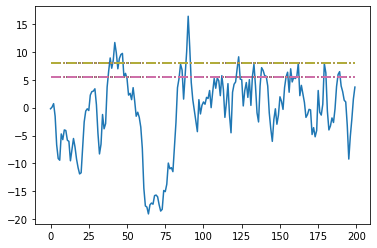

In [ ]:

plt.plot(one_channel)
#plt.scatter(spike_loc,one_channel[spike_loc],color='yellow',s=25)

x = np.zeros((len(one_channel),128))
y = (x + 1) * threshold
z = (x + 1) * variance
plt.plot(y,'-.')
plt.plot(z,'-.')


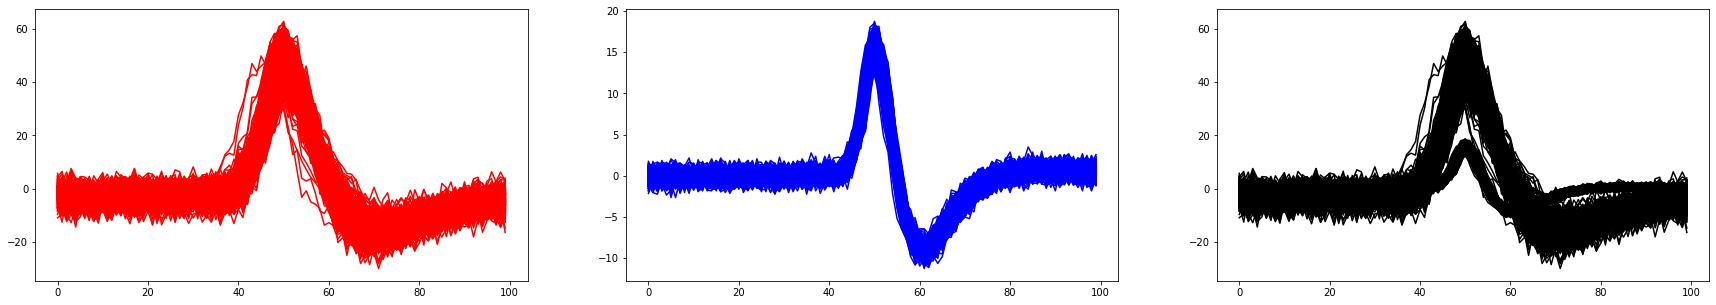

In [ ]:

plt.figure(figsize=(30, 5))
spike_wave = np.append(spike_wave_one, spike_wave_two, axis = 0)
plt.subplot(131)
for i in range(spike_wave_one.shape[0]):
    plt.plot(spike_wave_one[i],color='red')
plt.subplot(132)
for i in range(spike_wave_two.shape[0]):
    plt.plot(spike_wave_two[i],color='blue')
plt.subplot(133)
for i in range(spike_wave.shape[0]):
    plt.plot(spike_wave[i],color='black')

In [ ]:
mle = '2'
num_components = 2
pca = PCA(n_components = num_components)
pca.fit(spike_wave)
data_pca = pca.transform(spike_wave)

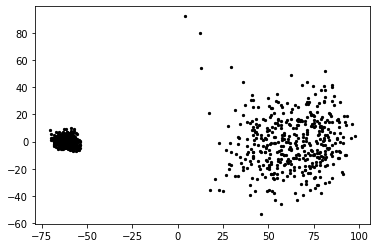

In [ ]:
for i in range(data_pca.shape[0]):
    plt.scatter(data_pca[i][0], data_pca[i][1],color = 'black', s = 5)
    

In [ ]:
data = data_pca
k = 2;
init_centroids = np.array(random.sample(list(data),k))
max_iters = 50
limit = 1e-5
K = len(init_centroids)

In [ ]:
def find_closest_centroids(X, centroids):
    # Set K
    K = centroids.shape[0]

    # You need to return the following variables correctly
    idx = np.zeros(X.shape[0], dtype=int)

    m = X.shape[0]
    ### START CODE HERE ###
    for i in range(m):
        
        distance = []
        
        for j in range(K):
            norm_ij = np.linalg.norm(X[i] - centroids[j])
            distance.append(norm_ij)
        idx[i] = np.argmin(distance)
    
    return idx


In [ ]:
idx = find_closest_centroids(data,init_centroids)

In [ ]:
def compute_centroids(X, idx, K):
    """
    Returns the new centroids by computing the means of the 
    data points assigned to each centroid.
    
    Args:
        X (ndarray):   (m, n) Data points
        idx (ndarray): (m,) Array containing index of closest centroid for each 
                       example in X. Concretely, idx[i] contains the index of 
                       the centroid closest to example i
        K (int):       number of centroids
    
    Returns:
        centroids (ndarray): (K, n) New centroids computed
    """
    
    # Useful variables
    m, n = X.shape
    
    # You need to return the following variables correctly
    centroids = np.zeros((K, n))
    
    ### START CODE HERE ###
    for k in range(K):
        points = X[idx == k]
        centroids[k] = np.mean(points,axis = 0)
    ### END CODE HERE ## 
    
    return centroids

In [ ]:
centroids = compute_centroids(data,idx,K)

In [ ]:
centroids

array([[ 28.46476076,  -0.25901879],
       [-63.59598966,   0.57869997]])

In [ ]:
def run_kMeans(X, initial_centroids, max_iters=10, plot_progress=False):
    """
    Runs the K-Means algorithm on data matrix X, where each row of X
    is a single example
    """
    
    # Initialize values
    m, n = X.shape
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    previous_centroids = centroids    
    idx = np.zeros(m)
    
    # Run K-Means
    for i in range(max_iters):
        
        #Output progress
        print("K-Means iteration %d/%d" % (i, max_iters-1))
        
        # For each example in X, assign it to the closest centroid
        idx = find_closest_centroids(X, centroids)
        
        # Optionally plot progress
        if plot_progress:
            plot_progress_kMeans(X, centroids, previous_centroids, idx, K, i)
            previous_centroids = centroids
            
        # Given the memberships, compute new centroids
        centroids = compute_centroids(X, idx, K)
    plt.show() 
    return centroids, idx

In [ ]:
centroids, idx = run_kMeans(data, init_centroids, max_iters, plot_progress=False)

K-Means iteration 0/49
K-Means iteration 1/49
K-Means iteration 2/49
K-Means iteration 3/49
K-Means iteration 4/49
K-Means iteration 5/49
K-Means iteration 6/49
K-Means iteration 7/49
K-Means iteration 8/49
K-Means iteration 9/49
K-Means iteration 10/49
K-Means iteration 11/49
K-Means iteration 12/49
K-Means iteration 13/49
K-Means iteration 14/49
K-Means iteration 15/49
K-Means iteration 16/49
K-Means iteration 17/49
K-Means iteration 18/49
K-Means iteration 19/49
K-Means iteration 20/49
K-Means iteration 21/49
K-Means iteration 22/49
K-Means iteration 23/49
K-Means iteration 24/49
K-Means iteration 25/49
K-Means iteration 26/49
K-Means iteration 27/49
K-Means iteration 28/49
K-Means iteration 29/49
K-Means iteration 30/49
K-Means iteration 31/49
K-Means iteration 32/49
K-Means iteration 33/49
K-Means iteration 34/49
K-Means iteration 35/49
K-Means iteration 36/49
K-Means iteration 37/49
K-Means iteration 38/49
K-Means iteration 39/49
K-Means iteration 40/49
K-Means iteration 41/49
K-

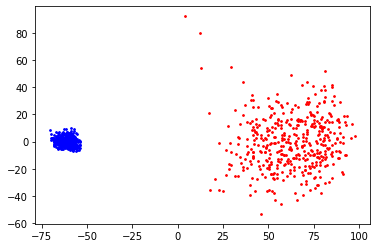

In [ ]:
color = ['red','blue','green','yellow','black']
for i in range(data.shape[0]):
        plt.scatter(data[i][0], data[i][1], color = color[idx[i]], s = 3)
